# Variety of NA-MD methods in Libra within NBRA


## Table of Content: <a name="TOC"></a>

1. [Generic setups](#1)

2. [Theoretical Background](#2)

   2.1. [Tully's Fewest Switches Surface Hopping (FSSH)](#2.1)
  
   2.2. [Global Flux Surface Hopping (GFSH)](#2.2)
   
   2.3. [Instantaneous Decoherence at Attempted hops (ID-A)](#2.3)
   
   2.4. [Modified Simplified Decay of Mixing method (MSDM)](#2.4)
   
   2.5. [Decoherence-Induced Surface Hopping (DISH)](#2.5)
   
   2.6. [Mapping Approach to Surface Hopping (MASH)](#2.6)
   
   2.7. [Fewests Switches Surface Hopping revised (FSSH2)](#2.7)
   
3. [File-based Hamiltonian](#3)

   3.1. [Read in the files](#3.1)
   
   3.2. [Define the Hamiltonian computation function](#3.2)

4. [Precompute and visualize key properties](#4)

   4.1. [Dephasing times and rates](#4.1)
   
   4.2. [Nonadiabatic couplings map](#4.2)

5. [Dynamics](#5)

   5.1. [Setting up simulation parameters](#5.1)
   
   5.2. [Running the dynamics](#5.2)
   
   5.3. [Visualizing the results of the dynamics and fitting the curves](#5.3)



## A. Learning objectives

- to know NA-MD methods available in Libra for use within NBRA workflows
- to be able to setup the NBRA NA-MD calculations for such methods and know the key difference in setups 
- to be able to pre-compute some reqired properties such as dephasing rates and average gaps
- to be able to define a file-based Hamiltonian computation functions
- to be able to setup initial conditions for electronic degrees of freedom in NBRA calculations with different methods
- to be able to plot dephasing times, average couplings, and population decay curves
- to be able fit the population decay curves, find the confidence intervals, and plot the fitted lines
- to be able to set up multithreading NA-MD calculations


## B. Use cases

- Read the vibronic Hamiltonian data files to obtain its properties
- Compute the time-averaged nonadiabatic couplings of the vibronic Hamiltonian
- Define adiabatic file-based model Hamiltonian
- Compute trajectory-averaged dephasing times
- Compute trajectory-averaged energy gaps
- Plot trajectory-averaged dephasing times
- Read the HDF5 files to plot results of dynamical calculations


## C. Functions

- `libra_py`
  - `data_visualize`
    - [`colors`](#colors-1)
    - [`clrs_index`](#clrs_index-1)
  - `dynamics`
    - `tsh`
      - `compute`
        - [`generic_recipe`](#generic_recipe-1)
  - `workflows`
    - `nbra`
      - `decoherence_times`
        - [`energy_gaps_ave`](#energy_gaps_ave-1)
        - [`decoherence_times_ave`](#decoherence_times_ave-1)        
       

## D. Classes and class members
    


## 1. Generic setups
<a name="1"></a>[Back to TOC](#TOC)

Here, we import all necessary libraries, set up some definitions (e.g. colors), and define the function that would be calling model Hamiltonians also defined within Libra package.

Note the section which imports recipes:
    
    from recipes import dish_nbra, fssh_nbra, fssh2_nbra, gfsh_nbra, ida_nbra, mash_nbra, msdm_nbra

These recipes are nothing but various combinations of parameters, chosen to represent particular known method.

Of course, one can consider other, less standard combinations and define new recipes. 

In [1]:
import os, glob, time, h5py, warnings

import multiprocessing as mp
import matplotlib.pyplot as plt   # plots
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit

from liblibra_core import *
import util.libutil as comn

import libra_py
from libra_py import units, data_conv #, dynamics_plotting
import libra_py.dynamics.tsh.compute as tsh_dynamics
#import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
#import libra_py.data_savers as data_savers
import libra_py.workflows.nbra.decoherence_times as decoherence_times
import libra_py.data_visualize

from recipes import dish_nbra, fssh_nbra, fssh2_nbra, gfsh_nbra, ida_nbra, mash_nbra, msdm_nbra

#from matplotlib.mlab import griddata
#%matplotlib inline 
warnings.filterwarnings('ignore')

/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vect

As another hint - the places of the main attention are marked by the hash-sign lines:

    ##########################################################################
    you most likely will want/need to modify something in between these lines
    ##########################################################################

## 2. Theoretical Background
<a name="2"></a>[Back to TOC](#TOC)

In this tutorial we consider the neglect-of-back-reaction (NBRA) approach to NA-MD simulations. Such calculations are usually done using a set of energy/coupling/time-overlap files pre-computed along ground-state molecular dynamics trajectories. This is a common approach for modeling NA-MD in atomistic systems. 

As such, all of the NBRA methods have a common set of parameters:

* `dyn_general.update({"ham_update_method":2})` - how to update Hamiltonian: recompute only adiabatic Hamiltonian; use with file-based or on-the-fly workflows

* `dyn_general.update( {"ham_transform_method":0 })` - how to transform the Hamiltonians between representations: don't do any transforms; usually for NBRA or on-the-fly workflows, so you don't override the read values

* `dyn_general.update( {"time_overlap_method":0 })` - how do get the time-overlaps in the dynamics: don't update time-overlaps - maybe they are already pre-computed and read

* `dyn_general.update({"nac_update_method":0 })` - how to compute NACs: just read from files
    
* `dyn_general.update( {"hvib_update_method":0 })` - how to compute vibronic Hamiltonian: don't update Hvib; maybe because we read it from files

* `dyn_general.update( {"force_method":0, "rep_force":1} )` - how to compute forces: don't compute forces

* `dyn_general.update({"hop_acceptance_algo":32, "momenta_rescaling_algo":0 })` - types of surface hopping acceptance and momenta rescaling opntions: accept with Boltzmann probability, do not rescale velocity


The parameters above are dictated by the availability of data and its representation - e.g. we usually don't have forces or diabatic Hamiltonian, so we usually don't know the diabatic-to-adiabatic transformation. We don't have derivative couplings or gradients, so we use the hop acceptance scheme that uses only energy. Because it is a NBRA, we don't need to change the nuclear trajectory, so we don't even rescale velocities. So, generally, we just read the key parameters - energies, coupling, and time-overlaps from files and make sure we tune the parameters that these read properties aren't accidentally overrited by the internal C++ procedures (e.g. such as ham or nac updates). 

The methods covered by these recipes include:

- FSSH

- GFSH

- IDA

- MSDM

- DISH

- MASH

- FSSH2


A more detailed theoretical background on most of these methods is given [in another tutorial](https://github.com/compchem-cybertraining/Tutorials_Libra/blob/master/6_dynamics/1_trajectory_based/10_model_many_methods/tutorial.ipynb). Here, we only discuss the parameters that are needed (in addition to the common NBRA-related parameters) to invoke such methods.

For the methods discussed in this tutorial, the NBRA formulation is possible. For other methods discussed in the tutorial on the non-NBRA methods (the link above), extra-properties such as gradiaents/forces, derivative couplings, or nuclear velocities may be needed. Since these properties are usually not available in NBRA calculations (for the kinds of systems that are studied with the NBRA approaches), the NBRA formulation of such methods is not possible or very problematic. 


### 2.1. Tully's Fewest Switches Surface Hopping (FSSH)
<a name="2.1"></a>[Back to TOC](#TOC)

* `recipes.fssh_nbra` - the recipe that sets up FSSH within NBRA. 

In this recipe, this method is selected by:

    dyn_general.update({"tsh_method":0 }) # FSSH
    
also, the recipe ensures tha no any decoherence corrections is added on top:

    dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence
    

### 2.2. Global Flux Surface Hopping (GFSH)
<a name="2.2"></a>[Back to TOC](#TOC)

* `recipes.gfsh_nbra` - the recipe that sets up GFSH within NBRA. 

In recipe, this method is selected by:

    dyn_general.update({"tsh_method":1 }) # GFSH

also, the recipe ensures tha no any decoherence corrections is added on top:

    dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence

 
### 2.3. Instantaneous Decoherence at Attempted hops (ID-A)
 <a name="2.3"></a>[Back to TOC](#TOC)
 
* `recipes.ida_nbra` - the recipe that sets up ID-A within NBRA. 
  
In the recipe, this option is selected by

    dyn_general.update({ "decoherence_algo":1}) # IDA    
    
together with

    dyn_general.update({"decoherence_times_type":-1 }) # No decoherence times, infinite decoherence times

Although the recipe doesn't state this explicitly, the reason why `"decoherence_algo":1` selects ID-A and not ID-S
is because the default parameter `"instantaneous_decoherence_variant":1` (for ID-A) is used. If you want to run ID-S calculations, add this instruction:

    dyn_general.update({ "instantaneous_decoherence_variant":0 }) # ID-S


### 2.4. Modified Simplified Decay of Mixing method (MSDM)
 <a name="2.4"></a>[Back to TOC](#TOC)
 
* `recipes.msdm_nbra` - the recipe that sets up MSDM within NBRA. This is essentially an SDM method of Granucci and Persico, but uses precomputed dephasing times instead of energy-based decoherence times. 

In the recipe, this method is selected as follows:

The hopping is taken as in FSSH:

    dyn_general.update({"tsh_method":0 }) # FSSH
    
The decoherence correction as given by the above formulas:

    dyn_general.update({ "decoherence_algo":0}) # msdm  
    
The pure dephasing rates are expected to be pre-computed:

    dyn_general.update( { "decoherence_times_type":0 } )  # manual decoherence times

To be able to use this method, it is critical that user also supplies (outside of the recipe) dephasing rates matrix as `MATRIX(nstates, nstates)` object, for instance:


    # Average decoherence times and rates
    _, rates = decoherence_times.decoherence_times_ave([HAM_RE], [0], NSTEPS, 0)

    dyn_general.update( {  "decoherence_rates":rates } ) 

    
### 2.5. Decoherence-Induced Surface Hopping (DISH)
 <a name="2.5"></a>[Back to TOC](#TOC)
 
 * `recipes.dish_nbra` - the recipe that sets up DISH within NBRA.
 
In the recipe, this method is selected as follows:

The hopping is taken as in FSSH:

    dyn_general.update({"tsh_method":5 }) # DISH
    
No additional decoherence correction is needed - all decoherence effects are already handled by the main DISH procedure:

    dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence
    
    
Similar to MSDM, the decoherence rates are expected to supplied manually and be pre-computed:

    dyn_general.update( { "decoherence_times_type":0 } )  # manual decoherence times

    # Average decoherence times and rates
    _, rates = decoherence_times.decoherence_times_ave([HAM_RE], [0], NSTEPS, 0)
    dyn_general.update( {  "decoherence_rates":rates } ) 


### 2.6. Mapping Approach to Surface Hopping (MASH)
<a name="2.6"></a>[Back to TOC](#TOC)

* `recipes.mash_nbra` - the recipe that sets up MASH within NBRA. This is the implementation of the many-states method of Runeson and Manolopoulos from [here](https://arxiv.org/abs/2305.08835)

In this recipe, this method is selected by:

    dyn_general.update({"tsh_method":6 }) # MASH
    
also, the recipe ensures tha no any decoherence corrections is added on top:

    dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence


### 2.7. Fewests Switches Surface Hopping revised (FSSH2)
<a name="2.7"></a>[Back to TOC](#TOC)

* `recipes.fssh2_nbra` - the revised version of FSSH within NBRA. This is based on the unpublished work of Leonardo Araujo

In this recipe, this method is selected by:

    dyn_general.update({"tsh_method":7 }) # FSSH2
    
also, the recipe ensures tha no any decoherence corrections is added on top:

    dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence


## 3. File-based Hamiltonian
<a name="3"></a>[Back to TOC](#TOC)

### 3.1. Read in the files
<a name="3.1"></a>[Back to TOC](#TOC)

In the NBRA approach, we usually setup the Hamiltonian computation function to return properties by retrieving them from the memory. So, although it is not the ideal approach, we will first read the files into global variables. The example data files are supplied with this tutorial in the `SD_basis_1.tar.bz2` archive. 

Start by unpacking it:

In [2]:
!tar -xf SD_basis_1.tar.bz2

Next, we read the files. The script below reads the vibronic Hamiltonian (`Hvib_*`) and time-overlap (`St_*`) files and creates the arrays of energy (`E`), time-overlaps (`St`), NACs (`NAC`), and vibronic Hamiltonians (`Hvib`) for future access. It automatically determines the number of states `nstates` or `NSTATES` (the dimensionality of the files).

The only parameter the user is to define here are the initial `istep` and final `fstep` indices of the data files to read. Their difference defines the length of the original data available for use `nsteps = NSTEPS`. Note, later the `nsteps` variable will be referred to the number of files available, whereas the `NSTEPS` will be re-defined to become the length of the actual NA-MD simulation. 

In [3]:
###########################################
istep = 1    # the first timestep to read
fstep = 1000 # the last timestep to read
###########################################

nsteps = fstep - istep
NSTEPS = nsteps
print(F"Number of steps = {nsteps}")

x = np.loadtxt(F'SD_basis_1/Hvib_sd_1_im')
nstates = x.shape[0]
NSTATES = nstates                                                            
print(F"Number of states = {nstates}")

#================== Read energies =====================
E = []
for step in range(istep,fstep):
    energy_filename = F"SD_basis_1/Hvib_sd_{step}_re"
    energy_mat = np.loadtxt(energy_filename)
    # For data conversion we need to turn np.ndarray to np.array so that 
    # we can use data_conv.nparray2CMATRIX
    E.append( np.array( np.diag( energy_mat ) ) )
E = np.array(E)

#================== Read time-overlap =====================
St = []
for step in range(istep,fstep):        
    St_filename = F"SD_basis_1/St_sd_{step}_re"
    St_mat = np.loadtxt(St_filename)
    St.append( np.array( St_mat ) )
St = np.array(St)
#================ Compute NACs and vibronic Hamiltonians along the trajectory ============    
NAC, Hvib = [], []
for c, step in enumerate(range(istep,fstep)):
    nac_filename = F"SD_basis_1/Hvib_sd_{step}_im"
    nac_mat = np.loadtxt(nac_filename)
    NAC.append( np.array( nac_mat ) )
    Hvib.append( np.diag(E[c, :])*(1.0+1j*0.0)  - (0.0+1j)*nac_mat[:, :] )
NAC = np.array(NAC)
Hvib = np.array(Hvib)

Number of steps = 999
Number of states = 37


### 3.2. Define the Hamiltonian computation function
<a name="3.2"></a>[Back to TOC](#TOC)

As mentioned above, this function only mimics computing the required properties, by simply grabbing needed matrices from the global variables created above

In [4]:
class abstr_class:
    pass

def compute_model(q, params, full_id):
    timestep = params["timestep"]
    nst = params["nstates"]
    obj = abstr_class()

    obj.ham_adi = data_conv.nparray2CMATRIX( np.diag(E[timestep, : ]) )
    obj.nac_adi = data_conv.nparray2CMATRIX( NAC[timestep, :, :] )
    obj.hvib_adi = data_conv.nparray2CMATRIX( Hvib[timestep, :, :] )
    obj.basis_transform = CMATRIX(nst,nst); obj.basis_transform.identity()  #basis_transform
    obj.time_overlap_adi = data_conv.nparray2CMATRIX( St[timestep, :, :] )
    
    return obj

## 4. Precompute and visualize key properties
<a name="4"></a>[Back to TOC](#TOC)

### 4.1. Dephasing times and rates
<a name="4.1"></a>[Back to TOC](#TOC)

Based on the global data loaded above, we can compute some properties that may be requred in future simulations, namely the averaged energy gaps and dephasing rates.

This is done in the following way:

In [5]:
# ================= Computing the energy gaps and decoherence times ===============
# Prepare the energies vs time arrays
HAM_RE = []
for step in range(E.shape[0]):
    HAM_RE.append( data_conv.nparray2CMATRIX( np.diag(E[step, : ]) ) )

# Average decoherence times and rates
tau, rates = decoherence_times.decoherence_times_ave([HAM_RE], [0], NSTEPS, 0)

# Computes the energy gaps between all states for all steps
dE = decoherence_times.energy_gaps_ave([HAM_RE], [0], NSTEPS)

# Decoherence times in fs
deco_times = data_conv.MATRIX2nparray(tau) * units.au2fs

# Zero all the diagonal elements of the decoherence matrix
np.fill_diagonal(deco_times, 0)

# Saving the average decoherence times [fs]
np.savetxt('decoherence_times.txt',deco_times.real)

# Computing the average energy gaps
gaps = MATRIX(NSTATES, NSTATES)
for step in range(NSTEPS):
    gaps += dE[step]
gaps /= NSTEPS

rates.show_matrix("decoherence_rates.txt")
gaps.show_matrix("average_gaps.txt")

Let's visualize the map of decoherence times:

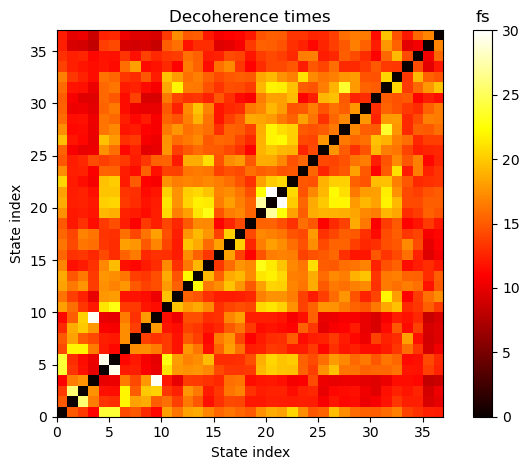

In [6]:
#%matplotlib notebook
%matplotlib inline 
plt.figure()
avg_deco = np.loadtxt('decoherence_times.txt')
nstates = avg_deco.shape[0]
plt.imshow(np.flipud(avg_deco), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=100)
plt.xlabel('State index')
plt.ylabel('State index')
colorbar = plt.colorbar()
colorbar.ax.set_title('fs')
plt.clim(vmin=0, vmax=30)
plt.title(F'Decoherence times')
plt.tight_layout()
plt.savefig('Decoherence_times.png')
plt.show()

### 4.2. Nonadiabatic couplings map
<a name="4.2"></a>[Back to TOC](#TOC)

We can also plot the map of averaged NACs

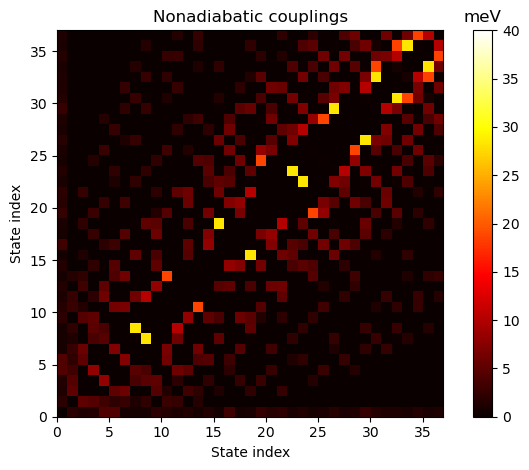

In [7]:
%matplotlib inline

# Compute averaged NACs
nac = np.zeros((NSTATES,NSTATES))
files = glob.glob('SD_basis_1/Hvib*im*')
for c, file in enumerate(files):
    tmp = np.loadtxt(file)
    nac += (np.abs(tmp)*1000*27.211385)
nac /= c
nstates = avg_deco.shape[0]

plt.figure()
plt.imshow(np.flipud(nac), cmap='hot', extent=(0,NSTATES,0,NSTATES))#, vmin=0, vmax=100)
plt.xlabel('State index')
plt.ylabel('State index')
colorbar = plt.colorbar()
colorbar.ax.set_title('meV')
plt.clim(vmin=0, vmax=40)
plt.title(F'Nonadiabatic couplings')
plt.tight_layout()
plt.savefig('Nonadiabatic_couplings.png', dpi=600)

## 5. Dynamics
<a name="5"></a>[Back to TOC](#TOC)

### 5.1. Setting up simulation parameters
<a name="5.1"></a>[Back to TOC](#TOC)

`model_params` should be initialized the way shown - some of the keywords are required; if omitted, the calculations may crash expectedly; Not much to discuss here. 

`dyn_general` - these are the parameters controlling the dynamics. A few special points of attention:

   - `NSTEPS` - as you can see, this number is chosen to be larger than the actual number of files read. Such calculations are allowed and would utilize the looping of the initial data. The looping will be done with the time-period controlled by the `nfiles` (998) parameter here. Basically, when the local "timestep" is larger than `nfiles`, the division remainder will be used to determine the index of the actual data to be used in such calculations. Note, the "timestep" takes into account the `icond` key of the `model_params` dictionary. That is if we have started with `icond == 301` and try doing `NSTEPS == 2000`, the index of the data used to compute step  1499 would be  301 + 1499 mod 998 = 802

   - `dt` - should be the same value as used in the nuclear dynamics (to produce time-overlaps and couplings), in a.u. of time
   
   - `rates` - are computed in the analysis above; these matrices are needed for some decoherence-corrected methods: DISH and MSDM, but not for others. If you want to do just do FSSH or IDA, you don't need it;
   
   - `gaps` - only needed if you plan on doing the `dephasing_informed == 1` option; if not - it is not needed;
   
   - `prefix` and `prefix2` - are needed; even though they are updated later on, it is important to have them here as well, or you may get some crashes; 
   
   - `mem_output_level` and `properties_to_save` - define a really minimalistic set of observables to compute/fook for, but it helps saving some disk space and speed up the calculations (overcoming the read/write bottleneck)
   

To select the method of choice, simply uncomment one of the lines that look like:

    mash_nbra.load(dyn_general); prf = "MASH"  # MASH
    
and, of course, comment the other methods.

What this instruction does it overrides the key-value pairs defined in `dyn_general` (or defines them, if they are not yet defined), according to the method of choice.

`nucl_params` - do not really matter for the NBRA calculations, so keep them as they are

`elec_params` - electronic parameters; mainly not much to choose here except for defining the state of interes (the one with index 3 in this example, that is this is 3-rd excited state). Note that the initialization of electronic variables in MASH is different from that in all other methods, but this is taken care of by the current script.

In [8]:
#================== Model parameters ====================
model_params = { "timestep":0, "icond":0,  "model0":0, "nstates":NSTATES }

#=============== Some automatic variables, related to the settings above ===================
#############
NSTEPS = 2000
#############

dyn_general = { "nsteps":NSTEPS, "ntraj":25, "nstates":NSTATES, "dt":20.0,
                "decoherence_rates":rates, "ave_gaps":gaps,                
                "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),
                "mem_output_level":2,
                "properties_to_save":[ "timestep", "time","se_pop_adi", "sh_pop_adi" ],
                "prefix":F"NBRA", "prefix2":F"NBRA", "isNBRA":0, "nfiles": nsteps - 1
              }
##########################################################
#============== Select the method =====================
#dish_nbra.load(dyn_general); prf = "DISH"  # DISH
#fssh_nbra.load(dyn_general); prf = "FSSH"  # FSSH
#fssh2_nbra.load(dyn_general); prf = "FSSH2"  # FSSH2
#gfsh_nbra.load(dyn_general); prf = "GFSH"  # GFSH
#ida_nbra.load(dyn_general); prf = "IDA"  # IDA
mash_nbra.load(dyn_general); prf = "MASH"  # MASH
#msdm_nbra.load(dyn_general); prf = "MSDM"  # MSDM
##########################################################

#=================== Initial conditions =======================
#============== Nuclear DOF: these parameters don't matter much in the NBRA calculations ===============
nucl_params = {"ndof":1, "init_type":3, "q":[-10.0], "p":[0.0], "mass":[2000.0], "force_constant":[0.01], "verbosity":-1 }

#============== Electronic DOF: Amplitudes are sampled ========
elec_params = {"ndia":NSTATES, "nadi":NSTATES, "verbosity":-1, "init_dm_type":0}

###########
istate = 3
###########
elec_params.update( {"init_type":1,  "rep":1,  "istate":istate } )  # how to initialize: random phase, adiabatic representation

if prf=="MASH":
    istates = list(np.zeros(NSTATES))
    istates[istate] = 1.0
    elec_params.update( {"init_type":4,  "rep":1,  "istate":3, "istates":istates } )  # different initialization for MASH

### 5.2. Running the dynamics
<a name="5.2"></a>[Back to TOC](#TOC)

To run the dynamics using multithreading, we create a single-parameter function that sets up the parameters, creates separate random numbers generator object and executed the calculations. This function `function1` is later passed to the `pool.map` function, which spawns several instances of the calculations. 

As our practice shows, one has to be really carefull how to setup the random number generators. If one uses a common random generator object, each instance of the spawned `function1` function will use almost the same sequence of the pseudo-random generated numbers. The reason if because all `Random` objects would be created nearly at the same time by the `pool.map`. As such, their random number initialization would be happening at nearly the same time. Since the system time is the most commonly-used way to pick the seed for the sequence of pseudorandom numbers and since such times would be very close for all thereads, one would basically run NA-MD calculations with nearly the same pseudorandom number sequences. The sampling would be poor. One could basically do just a single sequence of stochastic process of surface hopping. 

To initialize the seeds for each process, we use the `time.sleep` function with the wait time proportional to the initial condition index. In this way, the random number generators used by each thread would be sufficiently distinct and would produce different stochastic hopping trajectories. 

In [9]:
def function1(icond):
    print('Running the calculations for icond:', icond)
    time.sleep( icond * 0.01 )
    rnd=Random()
    mdl = dict(model_params)
    mdl.update({"icond": icond})  #create separate copy
    dyn_gen = dict(dyn_general)
    dyn_gen.update({"prefix":F"{prf}_icond_{icond}", "prefix2":F"{prf}_icond_{icond}" })
    res = tsh_dynamics.generic_recipe(dyn_gen, compute_model, mdl, elec_params, nucl_params, rnd)

Here, we finally start the calculations themselves.

We use 4 threads and 4 initial conditions (starting at files 1, 301, 601, and 901).

In [10]:
################################
nthreads = 4
ICONDS = list(range(1,1000,300))
################################

pool = mp.Pool(nthreads)
pool.map(function1, ICONDS)
pool.close()                            
pool.join()

Running the calculations for icond:Running the calculations for icond:Running the calculations for icond:Running the calculations for icond:    3011601901



 step= 0
Voron_mag[0]= 0.0299233
Voron_amp[0]= (-0.0784118,-0.154191)
Voron_mag[1]= 0.00852329
Voron_amp[1]= (0.0654562,0.0651058)
Voron_mag[2]= 0.00654617
Voron_amp[2]= (0.0239084,-0.0772953)
Voron_mag[3]= 0.091801
Voron_amp[3]= (-0.0687455,-0.295085)
Voron_mag[4]= 0.0282695
Voron_amp[4]= (-0.0670013,-0.154209)
Voron_mag[5]= 0.00951887
Voron_amp[5]= (0.0760678,-0.0610948)
Voron_mag[6]= 0.0148779
Voron_amp[6]= (0.101994,-0.0668966)
Voron_mag[7]= 0.00587788
Voron_amp[7]= (0.0703308,0.0305197)
Voron_mag[8]= 0.0298569
Voron_amp[8]= (0.122279,-0.122085)
Voron_mag[9]= 8.9285e-05
Voron_amp[9]= (0.00871538,0.00365064)
Voron_mag[10]= 0.000739138
Voron_amp[10]= (-0.017196,0.0210579)
Voron_mag[11]= 0.0347462
Voron_amp[11]= (0.170889,0.0744534)
Voron_mag[12]= 0.0011665
Voron_amp[12]= (0.0141348,0.0310918)
Voron_mag[13]= 0.00260351
Voron_amp[

 step= 0
Voron_mag[0]= 0.000202529
Voron_amp[0]= (-0.000899376,0.0142028)
Voron_mag[1]= 0.00256719
Voron_amp[1]= (-0.00885268,-0.0498881)
Voron_mag[2]= 0.0177326
Voron_amp[2]= (0.0864431,0.101292)
Voron_mag[3]= 0.121276
Voron_amp[3]= (-0.243827,0.248644)
Voron_mag[4]= 0.0429653
Voron_amp[4]= (-0.0359566,-0.204138)
Voron_mag[5]= 0.0406833
Voron_amp[5]= (0.172976,0.103743)
Voron_mag[6]= 0.000222737
Voron_amp[6]= (0.0115827,-0.00941159)
Voron_mag[7]= 0.00484491
Voron_amp[7]= (-0.0414904,-0.0558879)
Voron_mag[8]= 0.0388053
Voron_amp[8]= (-0.0712021,-0.183673)
Voron_mag[9]= 0.000901472
Voron_amp[9]= (-0.0113815,0.0277837)
Voron_mag[10]= 0.0306178
Voron_amp[10]= (0.121229,0.12618)
Voron_mag[11]= 0.0278411
Voron_amp[11]= (0.0121026,-0.166417)
Voron_mag[12]= 0.049969
Voron_amp[12]= (-0.110608,0.194255)
Voron_mag[13]= 0.00024972
Voron_amp[13]= (-0.0147701,0.00561814)
Voron_mag[14]= 0.00645286
Voron_amp[14]= (0.0693576,-0.0405262)
Voron_mag[15]= 0.0434179
Voron_amp[15]= (0.163477,-0.129202)
Voro

 step= 0
Voron_mag[0]= 0.013656
Voron_amp[0]= (-0.11674,0.00526462)
Voron_mag[1]= 0.0343866
Voron_amp[1]= (0.103517,-0.153853)
Voron_mag[2]= 0.0118027
Voron_amp[2]= (-0.0570595,0.0924495)
Voron_mag[3]= 0.103882
Voron_amp[3]= (0.0410933,-0.319678)
Voron_mag[4]= 0.00876245
Voron_amp[4]= (0.065887,0.0664932)
Voron_mag[5]= 0.0360557
Voron_amp[5]= (0.183127,0.0502002)
Voron_mag[6]= 0.0117865
Voron_amp[6]= (0.102556,-0.0356198)
Voron_mag[7]= 0.0258553
Voron_amp[7]= (0.129836,0.0948575)
Voron_mag[8]= 0.026686
Voron_amp[8]= (0.106815,0.123598)
Voron_mag[9]= 0.0267107
Voron_amp[9]= (-0.0604948,0.151826)
Voron_mag[10]= 0.0331346
Voron_amp[10]= (0.173895,-0.053807)
Voron_mag[11]= 0.00139615
Voron_amp[11]= (-0.0303595,0.0217819)
Voron_mag[12]= 0.0105681
Voron_amp[12]= (0.00385804,-0.102729)
Voron_mag[13]= 0.00257439
Voron_amp[13]= (-0.0192037,0.0469639)
Voron_mag[14]= 0.00394858
Voron_amp[14]= (-0.0392187,0.0490966)
Voron_mag[15]= 0.0389165
Voron_amp[15]= (-0.122536,0.154601)
Voron_mag[16]= 0.0325

 step= 0
Voron_mag[0]= 0.0183789
Voron_amp[0]= (0.133011,-0.026212)
Voron_mag[1]= 0.000353049
Voron_amp[1]= (0.00568485,0.017909)
Voron_mag[2]= 0.0900977
Voron_amp[2]= (0.213581,0.210905)
Voron_mag[3]= 0.137632
Voron_amp[3]= (0.279877,0.243517)
Voron_mag[4]= 0.0262373
Voron_amp[4]= (-0.0615262,-0.149839)
Voron_mag[5]= 0.0700818
Voron_amp[5]= (-0.246038,-0.0977098)
Voron_mag[6]= 0.01533
Voron_amp[6]= (0.102304,0.0697418)
Voron_mag[7]= 0.0183803
Voron_amp[7]= (-0.128427,0.0434365)
Voron_mag[8]= 0.0262264
Voron_amp[8]= (0.161082,-0.0166986)
Voron_mag[9]= 0.00711878
Voron_amp[9]= (0.0841647,0.00592214)
Voron_mag[10]= 0.0197403
Voron_amp[10]= (0.0153694,-0.139657)
Voron_mag[11]= 0.0175457
Voron_amp[11]= (-0.102026,0.0844773)
Voron_mag[12]= 0.0870194
Voron_amp[12]= (-0.113721,0.272189)
Voron_mag[13]= 0.0170228
Voron_amp[13]= (-0.116822,0.0580979)
Voron_mag[14]= 0.0127746
Voron_amp[14]= (-0.0720856,0.0870533)
Voron_mag[15]= 0.0114882
Voron_amp[15]= (0.0241951,-0.104416)
Voron_mag[16]= 0.00838

 step= 200
 step= 200
 step= 200
 step= 200
 step= 400
 step= 400
 step= 400
 step= 400
 step= 600
 step= 600
 step= 600
 step= 600
 step= 800
 step= 800
 step= 800
 step= 800
 step= 1000
 step= 1000
 step= 1000
 step= 1000
 step= 1200
 step= 1200
 step= 1200
 step= 1200
 step= 1400
 step= 1400
 step= 1400
 step= 1400
 step= 1600
 step= 1600
 step= 1600
 step= 1600
 step= 1800
 step= 1800
 step= 1800
 step= 1800
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi

### 5.3. Visualizing the results of the dynamics and fitting the curves
<a name="5.3"></a>[Back to TOC](#TOC)

First define a fitting function - usually this is an exponential decay function:

In [11]:
def exp_funct(t, _x):
    return np.exp(-np.power(t/_x, 1))

If you have computed the NA-MD results for all methods considered, you can plot the decay curves and their fits all together (commeted "for" line in the code block below).

If you have only comupted the dynamics for just one of the methods (MASH in the above example), you can plot the results for just that method, as shown below.

**Warning:** Make sure the folders (`iconds`) used for plotting form a subset of folders created during the NA-MD run. To do it, we simply use the same:

    for icond in range(1,1000,300)
    
line

Next, using the data pre-computed above, run the plot of the population vs. time

MASH_icond_1/mem_data.hdf
R2 = 0.9072891924398523
MASH_icond_301/mem_data.hdf
R2 = 0.9486074059299773
MASH_icond_601/mem_data.hdf
R2 = 0.4109918557472586
MASH_icond_901/mem_data.hdf
R2 = 0.40997876338574646
The timescales for method MASH: 1328.0693012855174+-166.52891355311152 fs, averaged over 4 samples


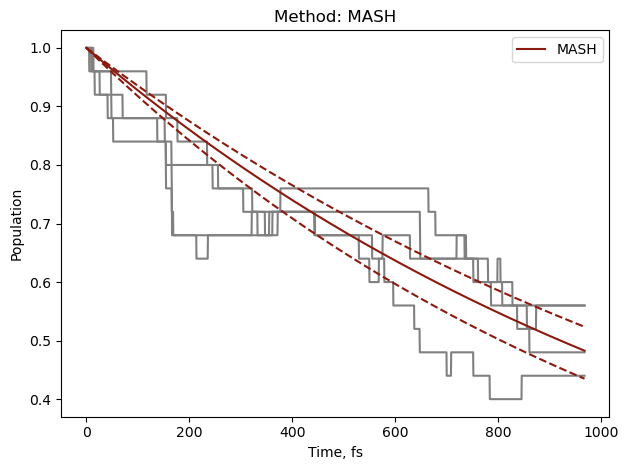

In [12]:
%matplotlib inline
#for c, method in enumerate(['FSSH', 'FSSH2', 'GFSH', 'MASH', 'MSDM', 'IDA', 'DISH']):
for c, method in enumerate(['MASH']):
    taus = []
    #for icond in range(1,1000,300):
    for icond in ICONDS:
        print( F'{method}_icond_{icond}/mem_data.hdf' )
        F = h5py.File(F'{method}_icond_{icond}/mem_data.hdf')                
        sh_pop = np.array(F['sh_pop_adi/data'][:,istate]) 
        se_pop = np.array(F['se_pop_adi/data'][:,istate]) 
        md_time = np.array(F['time/data'][:]) * units.au2fs
        plt.plot(md_time, sh_pop, color='gray')
        F.close()
        
        popt, pcov = curve_fit( exp_funct, md_time, sh_pop, bounds=([0.0],[np.inf]))
        _tau = popt
        
        # Computing the R-squared
        residuals  = sh_pop - exp_funct(md_time, *popt)
        ss_res     = np.sum(residuals**2)
        ss_tot     = np.sum((sh_pop - np.mean(sh_pop))**2)
        r_squared  = 1.0 - (ss_res / ss_tot)        
        print(F"R2 = {r_squared}")
        
        if True:#r_squared>0.1:
            taus.append(_tau)
        
    plt.ylabel('Population')
    plt.xlabel('Time, fs')
    plt.title(F'Method: {method}')
    
    taus = np.array(taus)    
    ave_tau = np.average(taus)
    s = np.std(taus)
    Z = 1.96
    N = taus.shape[0]
    error_bar = Z*s/np.sqrt(N)
    print(F'The timescales for method {method}: {ave_tau}+-{error_bar} fs, averaged over {len(taus)} samples')
    clr = libra_py.data_visualize.colors[ libra_py.data_visualize.clrs_index[c]]
    plt.plot(md_time, exp_funct(md_time, ave_tau-error_bar), ls='--', color=clr)
    plt.plot(md_time, exp_funct(md_time, ave_tau), ls='-',  color=clr, label=F"{method}")
    plt.plot(md_time, exp_funct(md_time, ave_tau+error_bar), ls='--', color=clr)
    plt.savefig('dynamics-mash.png')
    plt.legend()
    plt.tight_layout()

Alternatively, you can use the precomputed dynamics from the supplied archive:

In [13]:
!tar -xf namd_results.tar.bz2 | cp -r namd_results/* .

cp: cannot stat 'namd_results/*': No such file or directory


and then run the plotting for all the methods:

namd_results/FSSH_icond_1/mem_data.hdf
R2 = 0.8626937647770552
namd_results/FSSH_icond_301/mem_data.hdf
R2 = 0.8053118130435664
namd_results/FSSH_icond_601/mem_data.hdf
R2 = 0.913651202923317
namd_results/FSSH_icond_901/mem_data.hdf
R2 = 0.9228317073000207
The timescales for method FSSH: 554.8871299299228+-115.23112279354528 fs, averaged over 4 samples
namd_results/FSSH2_icond_1/mem_data.hdf
R2 = 0.8473962171406495
namd_results/FSSH2_icond_301/mem_data.hdf
R2 = 0.8529632078005787
namd_results/FSSH2_icond_601/mem_data.hdf
R2 = 0.8794486152058135
namd_results/FSSH2_icond_901/mem_data.hdf
R2 = 0.8020243021642639
The timescales for method FSSH2: 157.21768892165545+-7.284674552837423 fs, averaged over 4 samples
namd_results/GFSH_icond_1/mem_data.hdf
R2 = 0.9111724701266812
namd_results/GFSH_icond_301/mem_data.hdf
R2 = 0.8747868330355528
namd_results/GFSH_icond_601/mem_data.hdf
R2 = 0.8974392314198666
namd_results/GFSH_icond_901/mem_data.hdf
R2 = 0.8886055622017546
The timescales for method 

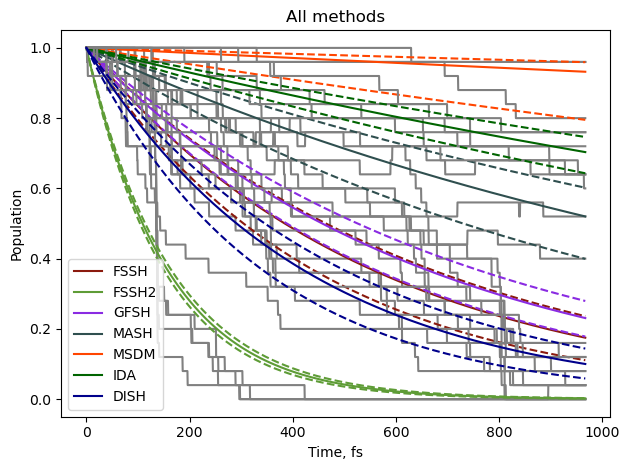

In [15]:
%matplotlib inline
for c, method in enumerate(['FSSH', 'FSSH2', 'GFSH', 'MASH', 'MSDM', 'IDA', 'DISH']):
    taus = []
    #plt.subplot(2,2,c+1)
    #for icond in range(1,1000,300):
    for icond in ICONDS:
        print( F'namd_results/{method}_icond_{icond}/mem_data.hdf' )
        F = h5py.File(F'namd_results/{method}_icond_{icond}/mem_data.hdf')                
        sh_pop = np.array(F['sh_pop_adi/data'][:,istate]) 
        se_pop = np.array(F['se_pop_adi/data'][:,istate]) 
        md_time = np.array(F['time/data'][:]) * units.au2fs
        plt.plot(md_time, sh_pop, color='gray')
        F.close()
        
        popt, pcov = curve_fit( exp_funct, md_time, sh_pop, bounds=([0.0],[np.inf]))
        _tau = popt
        
        # Computing the R-squared
        residuals  = sh_pop - exp_funct(md_time, *popt)
        ss_res     = np.sum(residuals**2)
        ss_tot     = np.sum((sh_pop - np.mean(sh_pop))**2)
        r_squared  = 1.0 - (ss_res / ss_tot)        
        print(F"R2 = {r_squared}")
        
        if True:#r_squared>0.1:
            taus.append(_tau)
        
    plt.ylabel('Population')
    plt.xlabel('Time, fs')
    plt.title(F'All methods')
    
    taus = np.array(taus)    
    ave_tau = np.average(taus)
    s = np.std(taus)
    Z = 1.96
    N = taus.shape[0]
    error_bar = Z*s/np.sqrt(N)
    print(F'The timescales for method {method}: {ave_tau}+-{error_bar} fs, averaged over {len(taus)} samples')
    clr = libra_py.data_visualize.colors[ libra_py.data_visualize.clrs_index[c]]
    plt.plot(md_time, exp_funct(md_time, ave_tau-error_bar), ls='--', color=clr)
    plt.plot(md_time, exp_funct(md_time, ave_tau), ls='-',  color=clr, label=F"{method}")
    plt.plot(md_time, exp_funct(md_time, ave_tau+error_bar), ls='--', color=clr)
    plt.savefig('dynamics-all.png')
    plt.legend()
    plt.tight_layout()